# AI FOR CT PROJECT COLAB
Tom Smith, Student No. 19010377 


# Initial Setup


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision import datasets, transforms

# CUDA CHECK
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
  print('NO CUDA CPU')
else:
  print('CUDA GPU')

CUDA GPU


In [2]:
# SETUP IMSHOW TO VISUALISE DATA
def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
!unzip '/content/gdrive/MyDrive/REGROUPED SAMPLE.zip' > /dev/null

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Preparing the Images

In [6]:
data_dir = 'REGROUPED SAMPLE'
batch_size = 14

# DEFINE TRANSFORMS
# TRAINING (with DATA AUGMENTATION)
train_transform = transforms.Compose([transforms.Resize(236),
                                transforms.RandomRotation(5), # RANDOM ROTATION
                                transforms.CenterCrop(224), # CENTER CROP
                                transforms.RandomHorizontalFlip(), # RANDOM FLIP
                                transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406],
                                                     [0.229, 0.224, 0.225])]) # NORMALISE FOR ALL COLOUR CHANNELS (REQUIRED FOR PRETRAINED MODEL)

 # VAL AND TEST (SAME AS TRAIN -DATA AUGMENTATION)
transform = transforms.Compose([transforms.Resize(224), 
                                transforms.CenterCrop(224), 
                                transforms.ToTensor(), 
                                transforms.Normalize([0.485, 0.456, 0.406],
                                                     [0.229, 0.224, 0.225])]) 
# SET THE DATASET FOLDERS
train_data = datasets.ImageFolder(data_dir + '/train', transform=transform)
val_data = datasets.ImageFolder(data_dir + '/val', transform=transform)
test_data = datasets.ImageFolder(data_dir + '/test', transform=transform)

# PREP LOADERS
train_loader = torch.utils.data.DataLoader(train_data, batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size, shuffle=True)

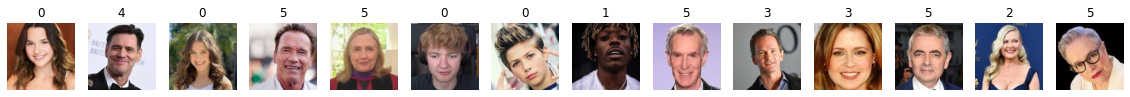

In [7]:
# FETCH ONE BATCH
data_iter = iter(train_loader)
images, labels = next(data_iter)
# DISPLAY LABELLED BATCH 
fig, axes = plt.subplots(figsize=(20,14), ncols=14)
for ii in range(14):
    ax = axes[ii]
    imshow(images[ii], ax=ax, normalize=True)
    ax.set_title(str(labels[ii].item())) 
# 0 = 10s, 1 = 20s, 2 = 30s, 3 = 40s, 4 = 50s, 5 = 60s

# Loading the model for training

In [28]:
import torch.nn as nn
import torchvision.models as models

# LOAD PRE-TRAINED RESNEXT NETWORK WITH 50 LAYERS
my_model = models.resnext50_32x4d(pretrained=True)



# CODE FOR FIXED FEATURE EXTRACTION
#for param in my_model.parameters():
#    param.requires_grad = False

#CODE FOR FINE TUNING
# GET INPUTS FOR FINAL LAYER
num_ftrs = my_model.fc.in_features
# SET OUTPUTS TO CLASS NUMBER
my_model.fc = nn.Linear(num_ftrs, 7)

if train_on_gpu:
    my_model.cuda()

print(my_model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1

In [29]:
import torch.optim as optim

# CROSS ENTROPY LOSS FUNCTION
criterion = nn.CrossEntropyLoss()
# ADAM OPTIMISER & LOSS RATE
optimizer = optim.Adam(my_model.parameters(), lr=0.00015)

# Training the Network

In [30]:
n_epochs = 25
valid_loss_min = np.Inf # STARTS AT INF FOR FIRST EPOCH

# TO STORE LOSSES
train_losses, val_losses = [], []

for epoch in range(n_epochs):
    # RESET LOSS FOR EACH EPOCH
    loss_trn = 0.0
    loss_val = 0.0    
    # TRAIN
    my_model.train() 
    for data, target in train_loader:
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # CLEAR OPTIMIZED VARS FROM GRADIENTS
        optimizer.zero_grad()
        # FORWARD PASS
        output = my_model(data)
        # CALCULATE LOSS
        loss = criterion(output, target)
        # BACK PASS
        loss.backward()
        # OPTIMIZER STEP
        optimizer.step()
        # UPDATE LOSS
        loss_trn += loss.item()*data.size(0)
                
    # VALIDATE
    my_model.eval() 
    for data, target in val_loader:
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # FOWARD PASS
        output = my_model(data)
        # CALCULATE LOSS
        loss = criterion(output, target)
        # UPDATE LOSS
        loss_val += loss.item()*data.size(0)
        
    # CALCULATE AND STORE EPOCH AVG LOSS
    loss_trn = loss_trn/len(train_loader.sampler)
    loss_val = loss_val/len(val_loader.sampler)
    train_losses.append(loss_trn)
    val_losses.append(loss_val)
    #PRINT EPOCH INFO
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch+1, 
        loss_trn,
        loss_val
        ))
    
    # IF LOWEST LOSS YET THEN SAVE MODEL 
    if loss_val <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        loss_val))
        torch.save(my_model.state_dict(), 'random_training_model.pt') # SAVED IN COLAB
        torch.save(my_model.state_dict(), '/content/gdrive/MyDrive/random_training_model.pt') # SAVED IN DRIVE
        valid_loss_min = loss_val

Epoch: 1 	Training Loss: 1.483026 	Validation Loss: 0.878459
Validation loss decreased (inf --> 0.878459).  Saving model ...
Epoch: 2 	Training Loss: 0.291007 	Validation Loss: 0.710941
Validation loss decreased (0.878459 --> 0.710941).  Saving model ...
Epoch: 3 	Training Loss: 0.099324 	Validation Loss: 1.078988
Epoch: 4 	Training Loss: 0.142333 	Validation Loss: 1.028790
Epoch: 5 	Training Loss: 0.121655 	Validation Loss: 0.895568
Epoch: 6 	Training Loss: 0.183104 	Validation Loss: 1.072027
Epoch: 7 	Training Loss: 0.195197 	Validation Loss: 1.666125
Epoch: 8 	Training Loss: 0.210125 	Validation Loss: 1.068822
Epoch: 9 	Training Loss: 0.161565 	Validation Loss: 1.078956
Epoch: 10 	Training Loss: 0.154663 	Validation Loss: 0.894823
Epoch: 11 	Training Loss: 0.099984 	Validation Loss: 1.084396
Epoch: 12 	Training Loss: 0.081577 	Validation Loss: 1.412366
Epoch: 13 	Training Loss: 0.049845 	Validation Loss: 1.196601
Epoch: 14 	Training Loss: 0.033616 	Validation Loss: 1.112033
Epoch: 1

# Visualise the Training Data

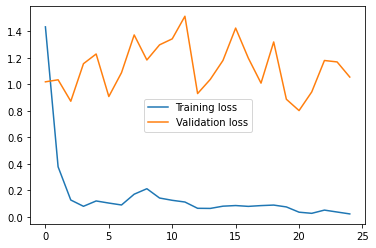

In [24]:
# PLOT DATA IN A GRAPH
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend(frameon=True)

In [27]:
# LOAD BEST MODEL FOR TESTING
my_model.load_state_dict(torch.load('random_training_model.pt'))
torch.save(my_model.state_dict(), '/content/gdrive/MyDrive/0.00016_training_model.pt') # SAVED IN DRIVE

# Testing the Network and Visualising Results

In [26]:
# INITIALISE LISTS TO EVALUATE MODEL
loss_tst = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

#LINE TO LOAD ANY MODEL TO TEST:
my_model.load_state_dict(torch.load('random_training_model.pt'))

my_model.eval() 

for data, target in test_loader:
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # FORWARD PASS
    output = my_model(data)
    # CALCULATE LOSS
    loss = criterion(output, target)
    # UPDATE TEST LOSS 
    loss_tst += loss.item()*data.size(0)
    # CONVERT OUTPUT PROBABILITES TO PREDICTED CLASS
    _, pred = torch.max(output, 1)
    # COMPARE PREDICT TO TRUE
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    # CALCULATE ACCURACY FOR EACH CLASS
    for i in range(len(target)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# CALCULATE AND PRINT AVG LOSS
loss_tst = loss_tst/len(test_loader.sampler)
print('Test Loss: {:.6f}\n'.format(loss_tst))


for i in range(6):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.849092

Test Accuracy of     0: 80% (16/20)
Test Accuracy of     1: 55% (11/20)
Test Accuracy of     2: 65% (13/20)
Test Accuracy of     3: 65% (13/20)
Test Accuracy of     4: 65% (13/20)
Test Accuracy of     5: 90% (18/20)

Test Accuracy (Overall): 70% (84/120)


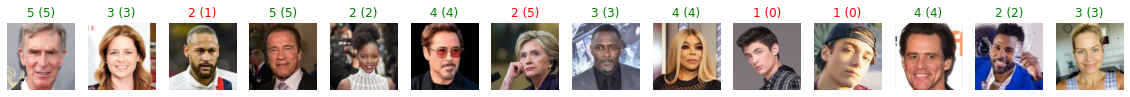

In [31]:
# VISUALISE SOME RESULTS

# GET A BATCH
dataiter = iter(test_loader)
images, labels = dataiter.next()
images.numpy()
if train_on_gpu:
    images = images.cuda()

# GET OUTPUTS
output = my_model(images)
# CONVERT OUTPUT PROBABILITES TO PREDICTED CLASS
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

# PLOT RESULTS
fig, axes = plt.subplots(figsize=(20,14), ncols=14)
for ii in range(14):
    ax = axes[ii]
    imshow(images.cpu()[ii], ax=ax, normalize=True)
    ax.set_title("{} ({})".format(str(preds[ii].item()), str(labels[ii].item())),
                 color=("green" if preds[ii]==labels[ii] else "red")) 